In [1]:
import pandas as pd
import yfinance as yf
import numpy as np
import datetime as dt
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from scipy.stats import norm

from pandas_datareader.famafrench import get_available_datasets
import pandas_datareader.data as web

# Create our portfolio of equities
tickers = ['AAPL','META', 'C', 'TSLA', 'MSFT', 'GOOGL', 'AMZN', 'DIS']

# Set the investment weights (arbitrarily picked for example)
weights = np.array([.125, .125, .125, .125, .125, .125, .125, .125,])

# Set an initial investment level
initial_investment = 1000000

#Timeline
start="2018-01-01"
end = "2023-04-28" #dt.date.today()

# Download closing prices
data = yf.download(tickers, start=start, end=end)["Adj Close"]

#From the closing prices, calculate periodic returns
returns = data.pct_change()
returns.dropna(inplace=True)

returns.tail()

[*********************100%***********************]  8 of 8 completed


,AAPL,AMZN,C,DIS,GOOGL,META,MSFT,TSLA
Date,,,,,,,,
2023-04-21,-0.009781,0.030344,-0.007490,0.015295,0.001140,-0.000845,-0.001223,0.012823
2023-04-24,0.001879,-0.007012,0.000000,0.001105,0.005313,-0.000470,-0.013963,-0.015326
2023-04-25,-0.009436,-0.034272,-0.023047,-0.016754,-0.020006,-0.024625,-0.022536,-0.011566
2023-04-26,-0.000061,0.023496,-0.021712,-0.014284,-0.001348,0.008913,0.072435,-0.043070
2023-04-27,0.028395,0.046104,0.003628,0.034365,0.037412,0.139255,0.032028,0.041886


# Naive approach

In [2]:
# Generate Var-Cov matrix
cov_matrix = returns.cov()
cov_matrix

,AAPL,AMZN,C,DIS,GOOGL,META,MSFT,TSLA
AAPL,0.000431,0.000303,0.000237,0.000206,0.000288,0.000334,0.000309,0.000402
AMZN,0.000303,0.000513,0.000184,0.000205,0.000309,0.000387,0.000316,0.000402
C,0.000237,0.000184,0.000583,0.000298,0.000232,0.000241,0.000226,0.000301
DIS,0.000206,0.000205,0.000298,0.000415,0.000215,0.000239,0.000208,0.000271
GOOGL,0.000288,0.000309,0.000232,0.000215,0.000400,0.000376,0.000311,0.000333
META,0.000334,0.000387,0.000241,0.000239,0.000376,0.000780,0.000335,0.000388
MSFT,0.000309,0.000316,0.000226,0.000208,0.000311,0.000335,0.000383,0.000364
TSLA,0.000402,0.000402,0.000301,0.000271,0.000333,0.000388,0.000364,0.001708


In [3]:
# Calculate mean returns for each stock
avg_rets = returns.mean()

# Calculate mean returns for portfolio overall, 
# using dot product to 
# normalize individual means against investment weights
port_mean = avg_rets.dot(weights)

# Calculate portfolio standard deviation
port_stdev = np.sqrt(weights.T.dot(cov_matrix).dot(weights))

# Calculate mean of investment
mean_investment = (1+port_mean) * initial_investment

print(mean_investment)

# Calculate standard deviation of investmnet
stdev_investment = initial_investment * port_stdev

print(stdev_investment)

1000884.2786442155
18394.31991303693


In [4]:
# Select our confidence interval (I'll choose 95% here)
conf_level1 = 0.05

# Using SciPy ppf method to generate values for the
# inverse cumulative distribution function to a normal distribution
# Plugging in the mean, standard deviation of our portfolio
# as calculated above

cutoff1 = norm.ppf(conf_level1, mean_investment, stdev_investment)

In [5]:
#Finally, we can calculate the VaR at our confidence interval
var_1d1 = initial_investment - cutoff1
var_1d1

#output
#22347.7792230231

29371.685180048924

1 day VaR @ 95% confidence: 29371.69
2 day VaR @ 95% confidence: 41537.84
3 day VaR @ 95% confidence: 50873.25
4 day VaR @ 95% confidence: 58743.37
5 day VaR @ 95% confidence: 65677.08
6 day VaR @ 95% confidence: 71945.64
7 day VaR @ 95% confidence: 77710.17
8 day VaR @ 95% confidence: 83075.67
9 day VaR @ 95% confidence: 88115.06
10 day VaR @ 95% confidence: 92881.42
11 day VaR @ 95% confidence: 97414.86
12 day VaR @ 95% confidence: 101746.5
13 day VaR @ 95% confidence: 105901.12
14 day VaR @ 95% confidence: 109898.78
15 day VaR @ 95% confidence: 113756.05


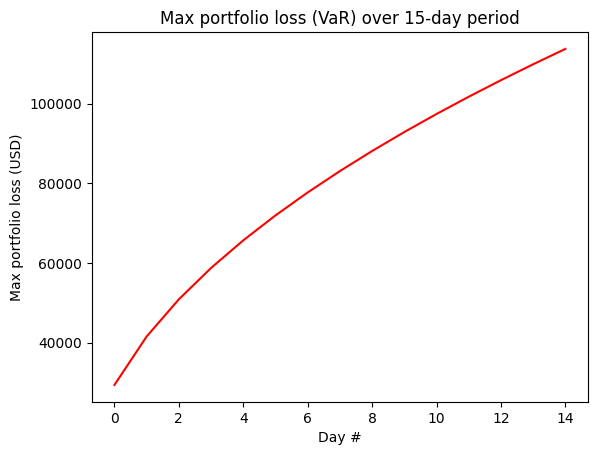

In [6]:
# Calculate n Day VaR
var_array = []
num_days = int(15)
for x in range(1, num_days+1):    
    var_array.append(np.round(var_1d1 * np.sqrt(x),2))
    print(str(x) + " day VaR @ 95% confidence: " + str(np.round(var_1d1 * np.sqrt(x),2)))

# Build plot
plt.xlabel("Day #")
plt.ylabel("Max portfolio loss (USD)")
plt.title("Max portfolio loss (VaR) over 15-day period")
plt.plot(var_array, "r")

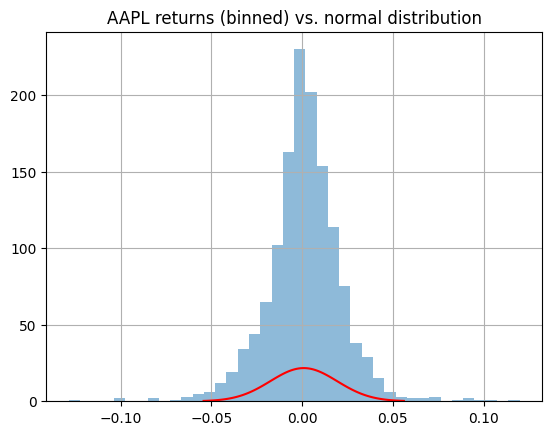

In [7]:
# Repeat for each equity in portfolio
returns['AAPL'].hist(bins=40,histtype="stepfilled",alpha=0.5)
x = np.linspace(port_mean - 3*port_stdev, port_mean+3*port_stdev,100)
plt.plot(x, norm.pdf(x, port_mean, port_stdev), "r")
plt.title("AAPL returns (binned) vs. normal distribution")
plt.show()

# PCA Approach

Python package sklearn.ensemble provides a Gradient boosting classifier	. For the purpose of illustration, we are demonstrating a classification problem with the help of gradient bossing. Boosting is a sequential process where misclassified observations from model 1 get more weight and then processed by Model 2.

__Method__: 

A gradient boosting classifier is created using the GradientBoostingClassifier class, specifying the number of estimators (base models) in the ensemble (n_estimators), the learning rate (learning_rate), and a random state for reproducibility. The boosting model is fitted to the training data using the fit method. Predictions are made on the test data using the predict method. Finally, the accuracy of the model is calculated by comparing the predicted labels with the actual labels of the test data.

__Common hyper-parameters__:

<ol>
  <li>n_estimators: The number of boosting stages (base models) to be performed.</li>
  <li>learning_rate: The contribution of each base model to the ensemble.</li>
  <li>max_depth: The maximum depth of each base model (tree-based boosters).</li>
  <li>mregularization parameters: Various regularization parameters, such as alpha, lambda, or gamma, depending on the specific boosting algorithm.</li>
</ol>

In [8]:
mu = returns.mean()
sig = returns.std()
returns_stdized = (returns - mu) / sig #returns
returns_stdized.dropna(inplace=True)
returns_stdized.head()

,AAPL,AMZN,C,DIS,GOOGL,META,MSFT,TSLA
Date,,,,,,,,
2018-01-03,-0.069714,0.532408,0.124996,0.203604,0.817409,0.619960,0.177266,-0.304681
2018-01-04,0.162269,0.166025,0.507810,-0.028895,0.158294,-0.087505,0.389178,-0.257661
2018-01-05,0.486758,0.681941,-0.058014,-0.273749,0.627289,0.468010,0.572967,0.093691
2018-01-08,-0.240162,0.605222,-0.486561,-0.710397,0.140594,0.252497,-0.008396,1.458676
2018-01-09,-0.066859,0.174841,0.430403,-0.042729,-0.099763,-0.099557,-0.095259,-0.252710


In [9]:
# Generate Var-Cov matrix
cov_matrix = returns_stdized.cov()
cov_matrix

,AAPL,AMZN,C,DIS,GOOGL,META,MSFT,TSLA
AAPL,1.000000,0.644175,0.472285,0.486239,0.692922,0.576594,0.761198,0.467968
AMZN,0.644175,1.000000,0.336536,0.443864,0.682317,0.611178,0.713940,0.429756
C,0.472285,0.336536,1.000000,0.606055,0.480125,0.358228,0.478553,0.301498
DIS,0.486239,0.443864,0.606055,1.000000,0.527243,0.420694,0.522026,0.322022
GOOGL,0.692922,0.682317,0.480125,0.527243,1.000000,0.673202,0.796070,0.402730
META,0.576594,0.611178,0.358228,0.420694,0.673202,1.000000,0.613171,0.336062
MSFT,0.761198,0.713940,0.478553,0.522026,0.796070,0.613171,1.000000,0.449648
TSLA,0.467968,0.429756,0.301498,0.322022,0.402730,0.336062,0.449648,1.000000


In [10]:
# Perform eigendecomposition

eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

# Put data into a DataFrame and save to excel
df_eigval = pd.DataFrame({"Eigenvalues": eigenvalues})

eigenvalues

array([4.72873015, 0.90641362, 0.73087273, 0.18084866, 0.28514939,
       0.31890585, 0.44103899, 0.40804061])

In [11]:
# We calculate explained variance

explained_variance = [round(variance / sum(eigenvalues), 4) for variance in eigenvalues]
explained_variance

[0.5911, 0.1133, 0.0914, 0.0226, 0.0356, 0.0399, 0.0551, 0.051]

In [12]:
sum(explained_variance)

1.0

In [13]:
columns = [
    "PC1",
    "PC2",
    "PC3",
    "PC4",
    "PC5",
    "PC6",
    "PC7",
    "PC8"
]
df_eigvec = pd.DataFrame(eigenvectors, columns=columns, index=returns.columns)
df_eigvec

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
AAPL,0.388826,-0.109300,-0.029047,-0.262406,0.578361,-0.448326,0.466304,0.119297
AMZN,0.371637,-0.313861,0.079283,-0.111092,0.261230,0.708475,0.022854,-0.417192
C,0.294104,0.684884,-0.020324,0.009039,0.056311,0.420943,0.126707,0.497516
DIS,0.319327,0.559291,0.042589,0.006535,0.042472,-0.299873,-0.308781,-0.629519
GOOGL,0.402425,-0.115020,0.199984,-0.558097,-0.675247,-0.085115,0.074075,0.068333
META,0.349248,-0.244375,0.303567,0.147878,0.195284,-0.118020,-0.703518,0.396590
MSFT,0.408556,-0.133274,0.083874,0.765064,-0.295587,-0.092655,0.353313,-0.046655
TSLA,0.267200,-0.130234,-0.922747,-0.003946,-0.104008,-0.013822,-0.213033,0.061426


In [14]:
from itertools import accumulate

df_eigval["Explained proportion"] = df_eigval["Eigenvalues"] / np.sum(
    df_eigval["Eigenvalues"]
)
df_eigval["Cumulative Explained Variance"] = list(
    accumulate(df_eigval["Explained proportion"])
)

# Format as percentage
df_eigval.style.format({"Explained proportion": "{:.2%}"})
df_eigval.style.format({"Cumulative Explained Variance": "{:.2%}"})

,Eigenvalues,Explained proportion,Cumulative Explained Variance
0,4.728730,0.591091,59.11%
1,0.906414,0.113302,70.44%
2,0.730873,0.091359,79.58%
3,0.180849,0.022606,81.84%
4,0.285149,0.035644,85.40%
5,0.318906,0.039863,89.39%
6,0.441039,0.055130,94.90%
7,0.408041,0.051005,100.00%


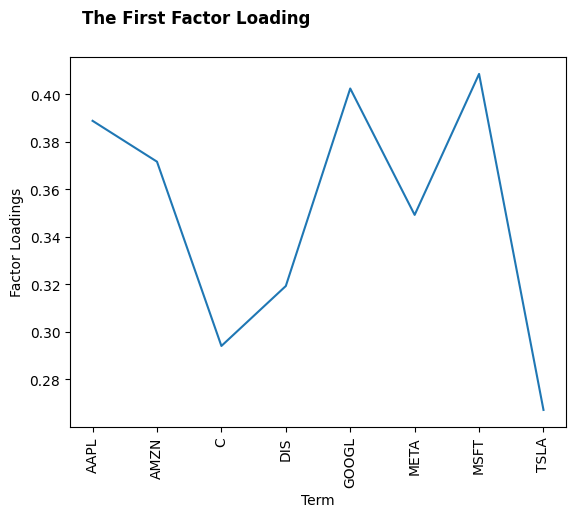

In [15]:
fig, ax = plt.subplots()

plt.plot(df_eigvec["PC1"])
plt.suptitle(
    "The First Factor Loading", fontweight="bold", horizontalalignment="right"
)
plt.ylabel("Factor Loadings")
ax.set_xticks(np.arange(8))
ax.set_xticklabels(returns.columns, rotation="vertical")
plt.xlabel("Term")
plt.show()

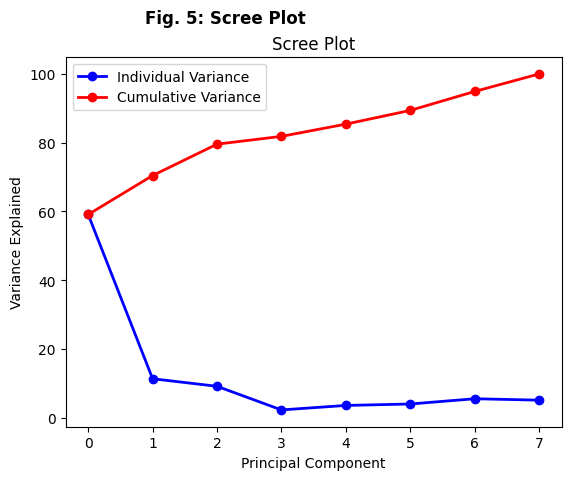

In [16]:
PC_values = np.arange(8)
plt.plot(
    PC_values, df_eigval["Explained proportion"] * 100, "o-", linewidth=2, color="blue"
)
plt.plot(
    PC_values,
    df_eigval["Cumulative Explained Variance"] * 100,
    "o-",
    linewidth=2,
    color="red",
)
plt.suptitle("Fig. 5: Scree Plot", fontweight="bold", horizontalalignment="right")
plt.title("Scree Plot")
plt.xlabel("Principal Component")
plt.ylabel("Variance Explained")
plt.legend(["Individual Variance", "Cumulative Variance"])
plt.show()

In [17]:
principal_components = returns_stdized.dot(eigenvectors)
principal_components.columns = df_eigvec.columns
principal_components.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
Date,,,,,,,,
2018-01-03,0.809012,-0.189468,0.698046,-0.266085,-0.337146,0.245058,-0.315437,-0.021677
2018-01-04,0.388212,0.246652,0.272388,0.140857,-0.047625,0.231655,0.418405,0.163056
2018-01-05,1.013232,-0.735160,0.258571,-0.048693,-0.066514,0.159571,0.219430,0.124532
2018-01-08,0.292684,-1.160988,-1.207334,-0.066562,-0.233228,0.483519,-0.421385,0.123730
2018-01-09,-0.029440,0.304721,0.180261,-0.029195,0.131791,0.380394,0.123377,0.102734


In [18]:
mean = (np.mean(principal_components, axis=0).to_numpy() + mu.to_numpy()) @ weights
stdev = np.sqrt(weights @ pd.DataFrame(np.diag(sig) @ np.asarray((eigenvectors @ principal_components.T).T.cov()) @ np.diag(sig).T) @ weights)

# Calculate mean of investment
mean_investment = (1+mean) * initial_investment

print(mean_investment)

# Calculate standard deviation of investmnet
stdev_investment = initial_investment * stdev

print(stdev_investment)

1000884.2786442155
18394.319913036932


# Fama-French Approach

In [19]:
get_available_datasets()

['F-F_Research_Data_Factors',
 'F-F_Research_Data_Factors_weekly',
 'F-F_Research_Data_Factors_daily',
 'F-F_Research_Data_5_Factors_2x3',
 'F-F_Research_Data_5_Factors_2x3_daily',
 'Portfolios_Formed_on_ME',
 'Portfolios_Formed_on_ME_Wout_Div',
 'Portfolios_Formed_on_ME_Daily',
 'Portfolios_Formed_on_BE-ME',
 'Portfolios_Formed_on_BE-ME_Wout_Div',
 'Portfolios_Formed_on_BE-ME_Daily',
 'Portfolios_Formed_on_OP',
 'Portfolios_Formed_on_OP_Wout_Div',
 'Portfolios_Formed_on_OP_Daily',
 'Portfolios_Formed_on_INV',
 'Portfolios_Formed_on_INV_Wout_Div',
 'Portfolios_Formed_on_INV_Daily',
 '6_Portfolios_2x3',
 '6_Portfolios_2x3_Wout_Div',
 '6_Portfolios_2x3_weekly',
 '6_Portfolios_2x3_daily',
 '25_Portfolios_5x5',
 '25_Portfolios_5x5_Wout_Div',
 '25_Portfolios_5x5_Daily',
 '100_Portfolios_10x10',
 '100_Portfolios_10x10_Wout_Div',
 '100_Portfolios_10x10_Daily',
 '6_Portfolios_ME_OP_2x3',
 '6_Portfolios_ME_OP_2x3_Wout_Div',
 '6_Portfolios_ME_OP_2x3_daily',
 '25_Portfolios_ME_OP_5x5',
 '25_Portf

$\mathbf{W}^T(\mathbf{BFB}^T + \mathbf{S})\mathbf{W}$

where
$$
\begin{align}
& \mathbf{F}= \begin{pmatrix}
\textrm{Var}(f_1) & \textrm{Cov}(f_1,f_2) & ... &  \textrm{Cov}(f_1,f_{N-1}) &  \textrm{Cov}(f_1,f_N) \\ 
\textrm{Cov}(f_2,f_1) & \textrm{Var}(f_2) & ... &  \textrm{Cov}(f_2,f_{N-1}) &  \textrm{Cov}(f_2,f_N) \\
... & ... & ... & ... & ... \\
\textrm{Cov}(f_{N-1},f_1) & \textrm{Cov}(f_{N-1},f_2) & ...& \textrm{Var}(f_{N-1}) &  \textrm{Cov}(f_{N-1},f_N) \\
\textrm{Cov}(f_N,f_1) & \textrm{Cov}(f_N,f_2) & ... &  \textrm{Cov}(f_N,f_{N-1}) &  \textrm{Var}(f_N) \\
\end{pmatrix}
\text{ is the covariance matrix of factors.}  \\
& \mathbf{B} = \begin{pmatrix}
\beta_{1,1} & \beta_{1,2} & ... &  \beta_{1,N-1} &  \beta_{1,N} \\ 
\beta_{2,1} & \beta_{2,2} & ... &  \beta_{2,N-1} &  \beta_{2,N} \\ 
... & ... & ... & ... & ... \\
\beta_{N-1,1} & \beta_{N-1,2} & ... &  \beta_{N-1,N-1} &  \beta_{N-1,N} \\ 
\beta_{N,1} & \beta_{N,2} & ... &  \beta_{N,N-1} &  \beta_{N,N} \\ 
\end{pmatrix}
\text{ is the matrix of factor exposures.}  \\
& \mathbf{S} = \begin{pmatrix}
\textrm{Var}(s_1) & 0 & ... & 0 & 0 \\ 
0 & \textrm{Var}(s_2) & ... &  0 &  0 \\
... & ... & ... & ... & ... \\
0 & 0 & ...& \textrm{Var}(s_{N-1}) &  0 \\
0 & 0 & ... &  0 &  \textrm{Var}(s_N) \\
\end{pmatrix}
\text{ is the matrix of specific variances.}  \\
& \mathbf{W} = \begin{pmatrix}
W_{1} \\
W_{2} \\
... \\
W_{N-1} \\
W_{N} \\
\end{pmatrix} \text{ is the vector of weight.}
\end{align}
$$

In [20]:
start = '07-1926'

In [21]:
ff=web.DataReader('F-F_Research_Data_Factors_daily','famafrench',start="2018-01-01", end = "2023-04-28")

/tmp/ipykernel_28928/3099762584.py:1: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ff=web.DataReader('F-F_Research_Data_Factors_daily','famafrench',start="2018-01-01", end = "2023-04-28")


In [22]:
ff

{0:             Mkt-RF   SMB   HML     RF
 Date                                 
 2018-01-02    0.85  0.35 -0.21  0.006
 2018-01-03    0.59 -0.39 -0.19  0.006
 2018-01-04    0.42 -0.26  0.25  0.006
 2018-01-05    0.66 -0.35 -0.25  0.006
 2018-01-08    0.19 -0.15  0.04  0.006
 ...            ...   ...   ...    ...
 2023-04-24    0.00 -0.40  0.47  0.018
 2023-04-25   -1.76 -0.99  0.10  0.018
 2023-04-26   -0.41  0.15 -0.75  0.018
 2023-04-27    1.85 -0.56  0.00  0.018
 2023-04-28    0.77  0.15  0.17  0.018
 
 [1340 rows x 4 columns],
 'DESCR': 'F-F Research Data Factors daily\n-------------------------------\n\nThis file was created by CMPT_ME_BEME_RETS_DAILY using the 202305 CRSP database. The Tbill return is the simple daily rate that, over the number of trading days in the month, compounds to 1-month TBill rate from Ibbotson and Associates Inc. Copyright 2023 Kenneth R. French\n\n  0 : (1340 rows x 4 cols)'}